In [255]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys
sys.path.append('..')
from pretty_midi_tokenization import create_sequences, KEY_ORDER, extract_bars_from_notes, notes_to_midi
import os
import pretty_midi
import collections

DIRECTORY_PATH = '..'
DATASET_PATH = os.path.join(DIRECTORY_PATH, 'dataset')
CHECKPOINTS_PATH = os.path.join(DIRECTORY_PATH, 'training_checkpoints')

KEY_ORDER = KEY_ORDER
BATCH_SIZE = 2
SEQ_LENGTH = 15
VOCAB_RANGE = [36, 72] # from C2 to C5
VOCAB_SIZE = VOCAB_RANGE[1] - VOCAB_RANGE[0] + 1
EPOCHS = 50 
LEARNING_RATE = 0.001
BPM = 120
BEATS_PER_BAR = 4

In [256]:
def midi_to_notes(midi_file_path: str, bpm = BPM, beats_per_bar = BEATS_PER_BAR) -> pd.DataFrame:

  pm = pretty_midi.PrettyMIDI(midi_file_path)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list) # Dictionary with values as list
  bar_duration = (60/bpm) * beats_per_bar

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:

    pitch = note.pitch
    start = note.start
    end = note.end
    step = start - prev_start
    duration = end - start
    bar = int(start // bar_duration) # integer part of the division
    
    notes['pitch'].append(pitch)
    notes['start'].append(start)
    notes['step'].append(step)
    notes['bar'].append(bar)

    # split the note in two if it spans multiple bars
    if start + duration > (bar + 1) * bar_duration: 

      # update the current note to end at the end of the bar and update its duration
      updated_end = (bar + 1) * bar_duration
      updted_duration = updated_end - start

      notes['end'].append(updated_end)
      notes['duration'].append(updted_duration)

      # create new note in the succeeding bar with the remaining duration
      succ_pitch = pitch  
      succ_start = (bar + 1) * bar_duration
      succ_end = end
      succ_step = succ_start - start
      succ_duration = succ_end - succ_start
      succ_bar = bar + 1

      notes['pitch'].append(succ_pitch)
      notes['start'].append(succ_start)
      notes['end'].append(succ_end)
      notes['step'].append(succ_step)
      notes['duration'].append(succ_duration)
      notes['bar'].append(succ_bar)

      prev_start = succ_start

    else:
      notes['end'].append(end)
      notes['duration'].append(duration)
      prev_start = start

  # create a dataframe from the notes dictionary
  notes_df = pd.DataFrame({name: np.array(value) for name, value in notes.items()})

  # put bar column at the end of the dataframe
  notes_df = notes_df[[col for col in notes_df.columns if col != 'bar'] + ['bar']]

  return notes_df

In [274]:
def create_sequences(
    in_bars: list,
    out_bars: list,  
    seq_length: int,
    vocab_range: list,
    vocab_size: int
) -> tf.data.Dataset:
  
  """
  Returns TF Dataset of sequence and label examples. 
  The latter is the next note of the sequence that has to be predicted.
  """

  key_order = ['pitch', 'step', 'duration']

  out_notes = pd.concat(out_bars)
  out_notes = np.stack([out_notes[key] for key in key_order], axis=1)

  in_notes = pd.concat(in_bars)
  in_notes = np.stack([in_notes[key] for key in key_order], axis=1) # get only 'key_order' columns from the dataframe

  # divide input into sequences of length `seq_length`shifted by 1 note each time
  sequences = []
  num_sequences = len(out_notes) - seq_length
  for i in range(1, num_sequences):
    seq = in_notes[i:i+seq_length]
    label = np.array([out_notes[i+seq_length]])

    # normalize the pitch values 
    label[:,0] -= vocab_range[0]
    seq[:, 0] -= vocab_range[0]
    seq[:, 0] /= vocab_size

    # print(seq.shape, label.shape)
    seq_and_label = np.concatenate((seq, label), axis=0)

    sequences.append(seq_and_label)

  # add 1 to seq_length to account for the label
  seq_length+=1 
  sequences = tf.data.Dataset.from_tensor_slices(sequences)
  
  # Split the labels from the input sequences
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(KEY_ORDER)}
    return inputs, labels
  
  sequences = sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

  return sequences, num_sequences

In [264]:
'''
Assumptions:
Sequences described as input_#.mid and output_#.mid in the corresponding folders
'''

input_filenames = glob.glob(os.path.join(DATASET_PATH, 'input/*.MID'))
print('Number of input files:', len(input_filenames))

output_filenames = glob.glob(os.path.join(DATASET_PATH, 'output/*.MID'))
print('Number of output files:', len(output_filenames))

for i, (in_file, out_file) in enumerate(zip(input_filenames, output_filenames)):

    in_file_name = os.path.basename(in_file)
    out_file_name = os.path.basename(out_file)

    print(f'\n{i + 1}: {in_file_name} -> {out_file_name}')
    in_notes = midi_to_notes(in_file)
    in_bars = extract_bars_from_notes(in_notes)
    print(f'Number of notes in input: {len(in_notes)}')
    print(f'Number of bars in input: {len(in_bars)}')

    out_notes = midi_to_notes(out_file)
    out_bars = extract_bars_from_notes(out_notes)
    print(f'Number of notes in output: {len(out_notes)}')
    print(f'Number of bars in output: {len(out_bars)}')

    # force in_bars and out_bars to have the same length
    min_len = min(len(in_bars), len(out_bars))
    in_bars = in_bars[:min_len]
    out_bars = out_bars[:min_len]


Number of input files: 1
Number of output files: 1

1: drum_excited.MID -> bass_example.MID
Number of notes in input: 486
Number of bars in input: 24
Number of notes in output: 38
Number of bars in output: 4


In [275]:
# create sequences
sequences, num_sequences = create_sequences(in_bars, out_bars, SEQ_LENGTH, VOCAB_RANGE, VOCAB_SIZE)

print('Number of sequences:', num_sequences)
for seq, target in sequences.take(2):
    print('sequence shape:', seq.shape)
    print('sequence first 3 elements:', seq[:3])
    print('target:', target)

Number of sequences: 23
sequence shape: (15, 3)
sequence first 3 elements: tf.Tensor(
[[0.         0.         0.22552083]
 [0.16216216 0.24479167 0.22708333]
 [0.05405405 0.25885417 0.21666667]], shape=(3, 3), dtype=float64)
target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=17.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.16666666666666652>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.125>}
sequence shape: (15, 3)
sequence first 3 elements: tf.Tensor(
[[-0.96859021  0.24479167  0.22708333]
 [-0.97151205  0.25885417  0.21666667]
 [-0.96859021  0.00416667  0.21302083]], shape=(3, 3), dtype=float64)
target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=16.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.16666666666666652>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.08333333333333348>}


In [276]:
def build_model(input_shape, learning_rate):

    def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
        mse = (y_true - y_pred) ** 2
        positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
        return tf.reduce_mean(mse + positive_pressure)
    

    inputs = tf.keras.Input(input_shape)
    x = tf.keras.layers.LSTM(128)(inputs)
    outputs = {
    'pitch': tf.keras.layers.Dense(VOCAB_SIZE, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
    }

    model = tf.keras.Model(inputs, outputs)

    loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
    }

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss=loss,
                  loss_weights={'pitch': 0.05,
                                'step': 1.0,
                                'duration':1.0},
                  optimizer=optimizer)

    model.summary()

    return model

In [277]:
buffer_size = num_sequences  # the number of items in the dataset
dataset = (sequences
            .shuffle(buffer_size)
            .batch(BATCH_SIZE, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

input_shape = (SEQ_LENGTH, len(KEY_ORDER))

model = build_model(input_shape, LEARNING_RATE)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = os.path.join(CHECKPOINTS_PATH, 'ckpt_{epoch}'),
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5, # Number of epochs with no improvement after which training will be stopped
        verbose=1,
        restore_best_weights=True),
]

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 15, 3)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  (None, 128)          67584       ['input_9[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_8[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 37)           4773        ['lstm_8[0][0]']                 
                                                                                            

In [278]:
history = model.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/50


11/11 [==============================] - 4s 37ms/step - loss: 0.2652 - duration_loss: 0.0381 - pitch_loss: 3.5721 - step_loss: 0.0485
Epoch 2/50
11/11 [==============================] - 0s 21ms/step - loss: 0.2109 - duration_loss: 0.0168 - pitch_loss: 3.4920 - step_loss: 0.0195
Epoch 3/50
11/11 [==============================] - 0s 20ms/step - loss: 0.1876 - duration_loss: 0.0071 - pitch_loss: 3.4374 - step_loss: 0.0086
Epoch 4/50
11/11 [==============================] - 0s 23ms/step - loss: 0.1826 - duration_loss: 0.0059 - pitch_loss: 3.3780 - step_loss: 0.0078
Epoch 5/50
11/11 [==============================] - 0s 24ms/step - loss: 0.1784 - duration_loss: 0.0058 - pitch_loss: 3.2988 - step_loss: 0.0076
Epoch 6/50
11/11 [==============================] - 0s 34ms/step - loss: 0.1730 - duration_loss: 0.0056 - pitch_loss: 3.1988 - step_loss: 0.0074
Epoch 7/50
11/11 [==============================] - 0s 34ms/step - loss: 0.1666 - duration_loss: 0.0057 - pitch_loss: 3.0682 - step_loss: 0.0

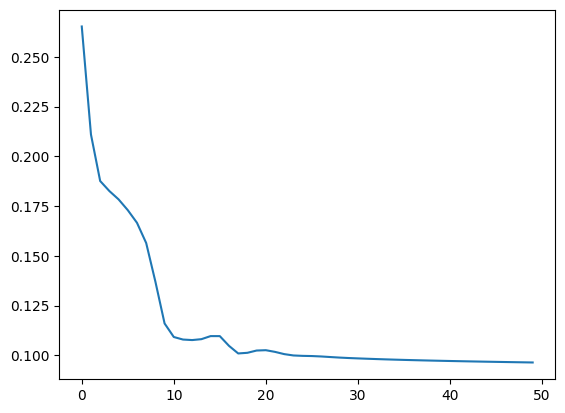

In [279]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [283]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  # pitch = tf.argmax(pitch_logits, axis=-1)
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  pitch+= VOCAB_RANGE[0]
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)




In [284]:
temperature = 2.0
num_predictions = 20

sample_notes = np.stack([in_notes[key] for key in KEY_ORDER], axis=1)
sample_notes[:, 0] -= VOCAB_RANGE[0]
sample_notes[:, 0] /= VOCAB_SIZE

# The initial sequence of notes; pitch is normalized 
input_notes = sample_notes[:SEQ_LENGTH]

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*KEY_ORDER, 'start', 'end'))

1/1 [==============================] - 0s 33ms/step


In [285]:
print(in_notes.head(20))

print(generated_notes.head(20))

    pitch     start      step       end  duration  bar
0      42  0.000000  0.000000  0.225521  0.225521    0
1      36  0.000000  0.000000  0.225521  0.225521    0
2      42  0.244792  0.244792  0.471875  0.227083    0
3      38  0.503646  0.258854  0.720313  0.216667    0
4      42  0.507812  0.004167  0.720833  0.213021    0
5      36  0.739062  0.231250  0.972396  0.233333    0
6      42  0.751042  0.011979  0.971354  0.220313    0
7      42  1.000000  0.248958  1.223437  0.223437    0
8      36  1.239062  0.239062  1.475521  0.236458    0
9      42  1.255208  0.016146  1.474479  0.219271    0
10     38  1.500521  0.245313  1.723958  0.223437    0
11     42  1.503125  0.002604  1.723958  0.220833    0
12     42  1.732812  0.229687  1.975000  0.242188    0
13     38  1.873437  0.140625  2.000000  0.126563    0
14     38  2.000000  0.126563  2.096875  0.096875    1
15     42  1.977604 -0.022396  2.000000  0.022396    0
16     42  2.000000  0.022396  2.221354  0.221354    1
17     36 

In [287]:
out_file = '../output/generated_bass_output.mid'
out_pm = notes_to_midi(
    out_notes, out_file=out_file, instrument_name='Acoustic Bass')